<a href="https://www.kaggle.com/code/harikrishnapillai/facerecognitioncnn?scriptVersionId=106891459" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/olivetti-faces/olivetti_faces_target.npy
/kaggle/input/olivetti-faces/olivetti_faces.npy


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt

In [3]:
import numpy as np
pics = np.load("/kaggle/input/olivetti-faces/olivetti_faces.npy")
labels = np.load("/kaggle/input/olivetti-faces/olivetti_faces_target.npy")

In [4]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

(400,)


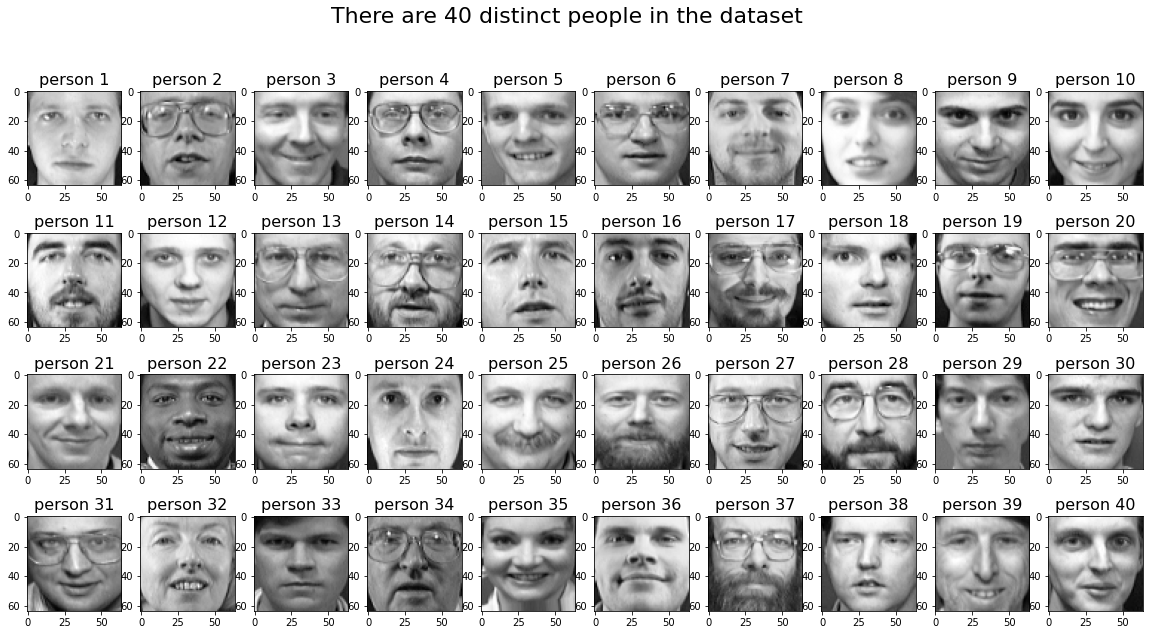

In [5]:
# print(pics[0])
print(labels.shape)
fig = plt.figure(figsize=(20, 10))
columns = 10
rows = 4
for i in range(1, columns*rows +1):
    img = pics[10*(i-1),:,:]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img,cmap='gray')
    plt.title("person {}".format(i), fontsize=16)
#     plt.axis('off')
    
plt.suptitle("There are 40 distinct people in the dataset", fontsize=22)
plt.show()

In [6]:
Xdata = pics
Ydata = labels.reshape(-1,1)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(Xdata, Ydata, test_size = 0.2, random_state=46)

print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

x_train:  (320, 64, 64)
x_test:  (80, 64, 64)
y_train:  (320, 1)
y_test:  (80, 1)


In [7]:
p = (12,45)
p=p + (14,69)
print(p)

(12, 45, 14, 69)


In [8]:
train_list = []
val_list = []
test_list = []
for i in range(x_train.shape[0]-20):
    train_list.append([torch.Tensor(x_train[i].reshape(1,64,64)),y_train[i][0]])
print(train_list[299][1])
for j in range(x_train.shape[0]-20,x_train.shape[0]):
    val_list.append([torch.Tensor(x_train[j].reshape(1,64,64)),y_train[j][0]])
for k in range(x_test.shape[0]):
    test_list.append([torch.Tensor(x_test[k].reshape(1,64,64)),y_test[k][0]])

print(val_list[0])
print(test_list[79][1])

39
[tensor([[[0.2397, 0.2645, 0.4463,  ..., 0.9256, 0.8802, 0.6612],
         [0.2562, 0.2562, 0.4793,  ..., 0.9174, 0.8967, 0.6570],
         [0.2645, 0.2603, 0.5372,  ..., 0.9091, 0.9215, 0.6736],
         ...,
         [0.1860, 0.3926, 0.8678,  ..., 0.2975, 0.1860, 0.2355],
         [0.1901, 0.5744, 0.9463,  ..., 0.5000, 0.1818, 0.2273],
         [0.3140, 0.7521, 0.9504,  ..., 0.6116, 0.2231, 0.1983]]]), 35]
3


In [9]:
# train_list = torch.Tensor(train_list)
# val_list = torch.Tensor(val_list)
# train_list = train_list.type(torch.LongTensor)
train_loader = torch.utils.data.DataLoader(dataset=train_list, batch_size=40 )

#Data Loader for validation data
val_loader = torch.utils.data.DataLoader(dataset=val_list, batch_size=40 )
# print(train_loader)

Feature batch shape: torch.Size([40, 1, 64, 64])
Labels batch shape: torch.Size([40])


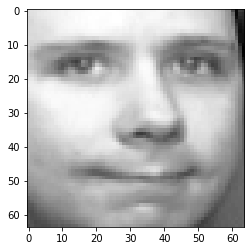

Label: 22


In [10]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [11]:
class FaceDetect(nn.Module):
    def __init__(self,out1=20,out2=50,out3=150,num_of_classes=40):
        super().__init__()
        # First CNN model
        self.cnn1 = nn.Conv2d(in_channels=1,out_channels=out1,kernel_size=5,padding=2)
        self.relu1 = nn.ReLU()
        self.conv1_bn = nn.BatchNorm2d(out1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.drop1 = nn.Dropout(0.25)
        self.cnn2 = nn.Conv2d(in_channels=out1,out_channels=out2,kernel_size=5,padding=2)
        self.relu2 = nn.ReLU()
        self.conv2_bn = nn.BatchNorm2d(out2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.drop2 = nn.Dropout(0.25)
        self.cnn3 = nn.Conv2d(in_channels=out2,out_channels=out3,kernel_size=5,padding=2)
        self.conv3_bn = nn.BatchNorm2d(out3)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(out3*16*16,256)
        
        # Second CNN model
        self.cnn11 = nn.Conv2d(in_channels=1,out_channels=out1,kernel_size=5,padding=2)
        self.relu11 = nn.ReLU()
        self.conv11_bn = nn.BatchNorm2d(out1)
        self.maxpool11 = nn.MaxPool2d(kernel_size=2)
        self.drop11 = nn.Dropout(0.25)
        self.cnn12 = nn.Conv2d(in_channels=out1,out_channels=out2,kernel_size=5,padding=2)
        self.relu12 = nn.ReLU()
        self.conv12_bn = nn.BatchNorm2d(out2)
        self.maxpool12 = nn.MaxPool2d(kernel_size=2)
        self.drop12 = nn.Dropout(0.25)
        self.cnn13 = nn.Conv2d(in_channels=out2,out_channels=out3,kernel_size=5,padding=2)
        self.conv13_bn = nn.BatchNorm2d(out3)
        self.relu13 = nn.ReLU()
        self.fc11 = nn.Linear(out3*16*16,256)
        
        # Ensembling both the models
        self.combine = nn.Linear(256*2,256)
        self.drop3 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(256,num_of_classes)
        self.soft = nn.Softmax(dim=1)
        
    def forward(self,x):
        x1 = self.cnn1(x)
        x1 = self.conv1_bn(x1)
        x1 = self.relu1(x1)
        x1 = self.maxpool1(x1)
        x1 = self.drop1(x1)
        x1 = self.cnn2(x1)
        x1 = self.relu2(x1)
        x1 = self.conv2_bn(x1)
        x1 = self.maxpool2(x1)
        x1 = self.drop2(x1)
        x1 = self.cnn3(x1)
        x1 = self.relu3(x1)
        x1 = self.conv3_bn(x1)
        x1 = x1.view(x.shape[0],-1)
        x1 = self.fc1(x1)
        
        x2 = self.cnn11(x)
        x2 = self.conv11_bn(x2)
        x2 = self.relu11(x2)
        x2 = self.maxpool11(x2)
        x2 = self.drop11(x2)
        x2 = self.cnn12(x2)
        x2 = self.relu12(x2)
        x2 = self.conv12_bn(x2)
        x2 = self.maxpool12(x2)
        x2 = self.drop12(x2)
        x2 = self.cnn13(x2)
        x2 = self.relu13(x2)
        x2 = self.conv13_bn(x2)
        x2 = x2.view(x.shape[0],-1)
        x2 = self.fc11(x2)
#         y = self.fc1(x1)+self.fc11(x2)
        y = torch.cat((x1,x2),1)
        x3 = self.combine(y)
        x3 = self.drop3(x3)
        x3 = self.fc2(x3)
#         x = self.soft(x)
        return x3
        

In [12]:
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
model = FaceDetect()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
lambda1 = lambda epoch: epoch // 30
lambda2 = lambda epoch: 0.95 ** epoch
scheduler = LambdaLR(optimizer, lr_lambda=lambda2)

train_acc_list = []
val_acc_list = []
len_train = len(train_list)
len_val = len(val_list)
epochs = 37
for epoch in range(epochs):
    correct = 0
    print(f"Epoch Num: {epoch}")
    
    for x,y in tqdm(train_loader):
        optimizer.zero_grad()
        y = y.type(torch.LongTensor)
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
#         target = torch.empty(batch_size, dtype=torch.long).random_(nb_classes)
#         print(type(y))
#         print(type(y_pred))
#         y = torch.LongTensor(y)
        loss = criterion(y_pred,y)
        loss.backward()
        optimizer.step()
        correct += (torch.argmax(y_pred,1)==y).sum().item()
#     print(correct)
    accuracy = correct/len_train
    print("Training Accuracy" + str(accuracy))
    train_acc_list.append((accuracy))
    
    correct=0
    model.eval()
    for x_val,y_val in tqdm(val_loader):
        y_val = y_val.type(torch.LongTensor)
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        z = model(x_val)
        y_pred = torch.argmax(z,1)
        correct += (y_pred==y_val).sum().item()
    accuracy = correct/len_val
    print("Validation Accuracy: " + str(accuracy))
    val_acc_list.append(accuracy)
    scheduler.step()
        
    

Epoch Num: 0


100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


Training Accuracy0.16666666666666666


100%|██████████| 1/1 [00:00<00:00, 246.20it/s]


Validation Accuracy: 0.05
Epoch Num: 1


100%|██████████| 8/8 [00:00<00:00, 51.61it/s]


Training Accuracy0.12


100%|██████████| 1/1 [00:00<00:00, 176.99it/s]


Validation Accuracy: 0.2
Epoch Num: 2


100%|██████████| 8/8 [00:00<00:00, 53.43it/s]


Training Accuracy0.32


100%|██████████| 1/1 [00:00<00:00, 225.44it/s]


Validation Accuracy: 0.4
Epoch Num: 3


100%|██████████| 8/8 [00:00<00:00, 53.13it/s]


Training Accuracy0.5966666666666667


100%|██████████| 1/1 [00:00<00:00, 229.17it/s]


Validation Accuracy: 0.6
Epoch Num: 4


100%|██████████| 8/8 [00:00<00:00, 53.77it/s]


Training Accuracy0.85


100%|██████████| 1/1 [00:00<00:00, 224.88it/s]


Validation Accuracy: 0.75
Epoch Num: 5


100%|██████████| 8/8 [00:00<00:00, 53.58it/s]


Training Accuracy0.9133333333333333


100%|██████████| 1/1 [00:00<00:00, 193.08it/s]


Validation Accuracy: 0.9
Epoch Num: 6


100%|██████████| 8/8 [00:00<00:00, 53.26it/s]


Training Accuracy0.9533333333333334


100%|██████████| 1/1 [00:00<00:00, 184.71it/s]


Validation Accuracy: 0.85
Epoch Num: 7


100%|██████████| 8/8 [00:00<00:00, 52.83it/s]


Training Accuracy0.9933333333333333


100%|██████████| 1/1 [00:00<00:00, 235.45it/s]


Validation Accuracy: 0.85
Epoch Num: 8


100%|██████████| 8/8 [00:00<00:00, 53.36it/s]


Training Accuracy0.9933333333333333


100%|██████████| 1/1 [00:00<00:00, 201.85it/s]


Validation Accuracy: 0.85
Epoch Num: 9


100%|██████████| 8/8 [00:00<00:00, 53.38it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 147.02it/s]


Validation Accuracy: 0.85
Epoch Num: 10


100%|██████████| 8/8 [00:00<00:00, 53.56it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 156.87it/s]


Validation Accuracy: 0.8
Epoch Num: 11


100%|██████████| 8/8 [00:00<00:00, 53.77it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 257.89it/s]


Validation Accuracy: 0.85
Epoch Num: 12


100%|██████████| 8/8 [00:00<00:00, 53.37it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 216.45it/s]


Validation Accuracy: 0.9
Epoch Num: 13


100%|██████████| 8/8 [00:00<00:00, 53.44it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 209.13it/s]


Validation Accuracy: 0.85
Epoch Num: 14


100%|██████████| 8/8 [00:00<00:00, 53.63it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 232.82it/s]


Validation Accuracy: 0.85
Epoch Num: 15


100%|██████████| 8/8 [00:00<00:00, 53.69it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 229.01it/s]


Validation Accuracy: 0.85
Epoch Num: 16


100%|██████████| 8/8 [00:00<00:00, 53.71it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 184.72it/s]


Validation Accuracy: 0.85
Epoch Num: 17


100%|██████████| 8/8 [00:00<00:00, 53.44it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 167.58it/s]


Validation Accuracy: 0.85
Epoch Num: 18


100%|██████████| 8/8 [00:00<00:00, 53.52it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 220.88it/s]


Validation Accuracy: 0.85
Epoch Num: 19


100%|██████████| 8/8 [00:00<00:00, 53.45it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 163.34it/s]


Validation Accuracy: 0.85
Epoch Num: 20


100%|██████████| 8/8 [00:00<00:00, 53.15it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 214.28it/s]


Validation Accuracy: 0.85
Epoch Num: 21


100%|██████████| 8/8 [00:00<00:00, 53.16it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 198.39it/s]


Validation Accuracy: 0.85
Epoch Num: 22


100%|██████████| 8/8 [00:00<00:00, 53.46it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 193.21it/s]


Validation Accuracy: 0.85
Epoch Num: 23


100%|██████████| 8/8 [00:00<00:00, 53.36it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 187.66it/s]


Validation Accuracy: 0.85
Epoch Num: 24


100%|██████████| 8/8 [00:00<00:00, 53.76it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 214.88it/s]


Validation Accuracy: 0.85
Epoch Num: 25


100%|██████████| 8/8 [00:00<00:00, 53.23it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 226.74it/s]


Validation Accuracy: 0.85
Epoch Num: 26


100%|██████████| 8/8 [00:00<00:00, 53.45it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 198.34it/s]


Validation Accuracy: 0.8
Epoch Num: 27


100%|██████████| 8/8 [00:00<00:00, 53.15it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 239.17it/s]


Validation Accuracy: 0.8
Epoch Num: 28


100%|██████████| 8/8 [00:00<00:00, 53.33it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 196.39it/s]


Validation Accuracy: 0.8
Epoch Num: 29


100%|██████████| 8/8 [00:00<00:00, 53.67it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 213.06it/s]


Validation Accuracy: 0.8
Epoch Num: 30


100%|██████████| 8/8 [00:00<00:00, 53.03it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 230.60it/s]


Validation Accuracy: 0.8
Epoch Num: 31


100%|██████████| 8/8 [00:00<00:00, 53.51it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 207.80it/s]


Validation Accuracy: 0.8
Epoch Num: 32


100%|██████████| 8/8 [00:00<00:00, 53.64it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 272.96it/s]


Validation Accuracy: 0.8
Epoch Num: 33


100%|██████████| 8/8 [00:00<00:00, 53.59it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 224.63it/s]


Validation Accuracy: 0.8
Epoch Num: 34


100%|██████████| 8/8 [00:00<00:00, 53.71it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 126.08it/s]


Validation Accuracy: 0.8
Epoch Num: 35


100%|██████████| 8/8 [00:00<00:00, 53.38it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 225.74it/s]


Validation Accuracy: 0.8
Epoch Num: 36


100%|██████████| 8/8 [00:00<00:00, 53.24it/s]


Training Accuracy1.0


100%|██████████| 1/1 [00:00<00:00, 201.65it/s]

Validation Accuracy: 0.8


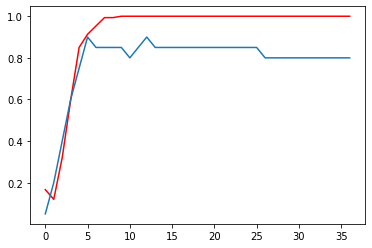

In [13]:
axis = []
for h in range(37):
    axis.append(h)
plt.plot(axis,train_acc_list,color="red")
plt.plot(axis,val_acc_list)

35
AI's Prediction: tensor(35, device='cuda:0')


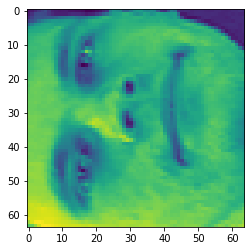

In [14]:
import random
def show_data(data_sample,size):
  plt.imshow(data_sample[0].numpy().T)
  print(data_sample[1])
#   plt.title(f"Real Label = 8")
IMAGE_SIZE = 16
model.to(device)
model.eval()
randomIndex = random.randint(0, len(test_list) - 1)
test = test_list[randomIndex]
show_data(test, IMAGE_SIZE)
# Turn image of (C, H, W) into (B, C, H, W) to pass into the model
# Take the index of the highest probability from the output tensor and grab the corresponding classification
x_test = test[0].view(-1, 1, 64, 64).to(device)
print("AI's Prediction: " + str(torch.argmax(model(x_test), 1)[0]))
# plt.imshow(data_sample[][0].numpy().T)

In [15]:
torch.cuda.is_available()

True